<a href="https://colab.research.google.com/github/sanjibani/RAG-learnings/blob/main/langchain_sql_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!unzip -q chinook.zip -d /content/extracted/

unzip:  cannot find or open chinook.zip, chinook.zip.zip or chinook.zip.ZIP.


In [4]:
%%capture --no-stderr
%pip install --upgrade --quiet langchain-community langgraph

In [5]:
# Comment out the below to opt-out of using LangSmith in this notebook. Not required.
import os
import getpass
if not os.environ.get("LANGSMITH_API_KEY"):
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass()
    os.environ["LANGSMITH_TRACING"] = "true"

··········


In [8]:
import os
import sqlite3

# Check file size
db_file = '/content/chinook_3.db'
file_size = os.path.getsize(db_file)
print(f"Chinook.db file size: {file_size} bytes")

if file_size == 0:
    print("ERROR: File is 0 bytes - extraction failed!")
else:
    print("File has data - checking if it's a valid SQLite database...")



Chinook.db file size: 884736 bytes
File has data - checking if it's a valid SQLite database...


In [9]:
import sqlite3

try:
    # Test direct connection
    conn = sqlite3.connect('/content/chinook_3.db')
    cursor = conn.cursor()

    # Try to query the database
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    print(f"SUCCESS! Tables found: {tables}")

    # Test a simple query
    cursor.execute("SELECT COUNT(*) FROM sqlite_master;")
    count = cursor.fetchone()[0]
    print(f"Number of database objects: {count}")

    conn.close()
    print("Direct sqlite3 connection works!")

except Exception as e:
    print(f"Direct sqlite3 connection failed: {e}")


SUCCESS! Tables found: [('albums',), ('sqlite_sequence',), ('artists',), ('customers',), ('employees',), ('genres',), ('invoices',), ('invoice_items',), ('media_types',), ('playlists',), ('playlist_track',), ('tracks',), ('sqlite_stat1',)]
Number of database objects: 24
Direct sqlite3 connection works!


In [10]:
import os
from langchain_community.utilities import SQLDatabase

db_path = os.path.abspath("/content/chinook_3.db")  # absolute path on Linux
print("Using:", db_path)

db = SQLDatabase.from_uri(f"sqlite:///{db_path}")  # SQLAlchemy absolute SQLite URL
print(db.dialect)
print(sorted(db.get_usable_table_names()))

# Sanity checks
print(db.run("SELECT name FROM sqlite_master WHERE type='table';"))
print(db.run("SELECT * FROM artists LIMIT 10;"))  # table names in Chinook are typically lowercase


Using: /content/chinook_3.db
sqlite
['albums', 'artists', 'customers', 'employees', 'genres', 'invoice_items', 'invoices', 'media_types', 'playlist_track', 'playlists', 'tracks']
[('albums',), ('sqlite_sequence',), ('artists',), ('customers',), ('employees',), ('genres',), ('invoices',), ('invoice_items',), ('media_types',), ('playlists',), ('playlist_track',), ('tracks',), ('sqlite_stat1',)]
[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]


In [11]:
from typing_extensions import TypedDict

class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

In [34]:

pip install -U langchain-community


In [25]:
import getpass
import os

os.environ["ANTHROPIC_API_KEY"] = getpass.getpass("Enter API key for Anthropic: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("claude-3-5-sonnet-latest", model_provider="anthropic")

Enter API key for Anthropic: ··········


In [26]:
from langchain_core.prompts import ChatPromptTemplate

system_message = """
Given an input question create a syntactically correct {dialect} query to run
to help find the answer. Unless the user specifies in his question to obtain
a specific number of examples they wish to obtain, always limit the query to
atmost {top_k} results. You an order the results by relevant  column to return
most interesting examples in the database

Never queryfor all the columns from a specific table , only ask for the few relevant columns
given the question.

Pay attention to use only the column names you can see in the tables below.
Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

only use the following tables:
{table_info}
"""

user_input = "Questions: {input}"

query_prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", system_message),
        ("user", user_input),
    ]
)

for message in query_prompt_template.messages:
    message.pretty_print()

================================ System Message ================================


Given an input question create a syntactically correct {dialect} query to run
to help find the answer. Unless the user specifies in his question to obtain
a specific number of examples they wish to obtain, always limit the query to
atmost {top_k} results. You an order the results by relevant  column to return
most interesting examples in the database

Never queryfor all the columns from a specific table , only ask for the few relevant columns
given the question.

Pay attention to use only the column names you can see in the tables below.
Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

only use the following tables:
{table_info}

================================ Human Message =================================

Questions: {input}


In [56]:
from typing_extensions import Annotated

class QueryOutput():
  """ Generated SQL Query."""

  query: Annotated[str, ... , "The generated SQL query"]


def write_query(state: State):
  """Generate SQL query to fetch information."""
  prompt = query_prompt_template.invoke(
      {
          "input": state["question"],
          "dialect": db.dialect,
          "table_info": db.get_table_info(),
          "top_k": 10,
      }
  )
  print(prompt.pretty_print())
  structured_llm = llm.with_structured_output(QueryOutput)
  result = structured_llm.invoke(prompt)
  print("LLM Result:", result) # This line is already here, keep it.
  print("Type of LLM Result:", type(result)) # Add this line
  print("Keys in LLM Result:", result.keys() if hasattr(result, 'keys') else "Result does not have keys()") # Add this line

  return {"query": result["query"]}

In [29]:
write_query({"question": "How many artists are there?"})

{'query': 'SELECT COUNT(ArtistId) as artist_count FROM artists;'}

In [35]:
#execute query
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool

def execute_query(state:State):
  """Execure the sql query."""
  execute_tool_query = QuerySQLDataBaseTool(db=db)
  return { "result":execute_tool_query.invoke(state["query"])}



In [38]:
execute_query({"query": "SELECT COUNT(EmployeeId) AS EmployeeCount FROM Employees;"})

{'result': '[(8,)]'}

In [40]:
def generate_answer(state: State):
  """ answer question using  retrieved information as context """
  prompt  = (
      "given the following user question , corresponding sql query"
      "and the sql response , answer the following user questions. \n\n"
      f"Question : {state['question']} \n"
      f"Query : {state['query']} \n"
      f"Result : {state['result']} \n"
  )

  return {"answer": llm.invoke(prompt).content}

In [43]:
# orchestrating lang graphnow

from langgraph.graph import START , END , StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query , execute_query ,  generate_answer]
)
graph_builder.add_edge(START , "write_query")

graph = graph_builder.compile();

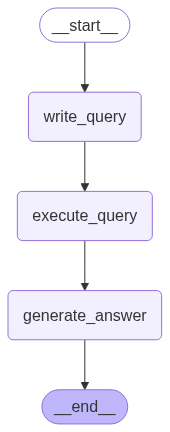

In [45]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [48]:
for step in graph.stream(
    {"question": "which ocmposer made the most money"} , stream_mode = "updates"
):
  print(step)


{'write_query': {'query': 'SELECT t.Composer, \n       SUM(ii.UnitPrice * ii.Quantity) as TotalRevenue\nFROM tracks t\nJOIN invoice_items ii ON t.TrackId = ii.TrackId\nWHERE t.Composer IS NOT NULL\nGROUP BY t.Composer\nORDER BY TotalRevenue DESC\nLIMIT 10;'}}
{'execute_query': {'result': "[('Steve Harris', 57.42000000000003), ('U2', 32.66999999999998), ('Billy Corgan', 22.769999999999992), ('Titãs', 21.779999999999994), ('Bill Berry-Peter Buck-Mike Mills-Michael Stipe', 21.779999999999994), ('Herbert Vianna', 20.789999999999996), ('J.C. Fogerty', 18.81), ('Billie Joe Armstrong -Words Green Day -Music', 17.82), ('R.E.M.', 16.830000000000002), ('Gilberto Gil', 16.830000000000002)]"}}
{'generate_answer': {'answer': "Based on the SQL query results, Steve Harris made the most money with a total revenue of $57.42. He is followed by U2 with $32.67 and Billy Corgan with $22.77.\n\nThe query calculates the total revenue for each composer by multiplying the unit price of tracks by the quantity s

In [62]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver();
graph = graph_builder.compile(checkpointer=memory , interrupt_before= ["execute_query"] );

config = {"configurable": {"thread_id": "1"}}

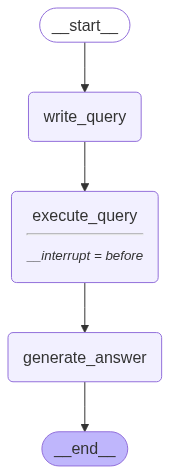

In [63]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [64]:
for step in graph.stream(
    {"question": "How many employees are there?"},
    config,
    stream_mode="updates",
):
    print(step)

try:
    user_approval = input("Do you want to go to execute query? (yes/no): ")
except Exception:
    user_approval = "no"

if user_approval.lower() == "yes":
    # If approved, continue the graph execution
    for step in graph.stream(None, config, stream_mode="updates"):
        print(step)
else:
    print("Operation cancelled by user.")

{'write_query': {'query': 'SELECT COUNT(*) AS employee_count FROM employees;'}}
{'__interrupt__': ()}
Do you want to go to execute query? (yes/no): yes
{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': 'Based on the SQL query result, there are 8 employees in total.\n\nThe query counted all records (*) in the employees table using COUNT(), and returned a single value of 8, indicating that there are 8 employee records in the database.'}}


In [68]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit( db=db , llm=llm)
tools = toolkit;

tools


SQLDatabaseToolkit(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7e4544223740>, llm=ChatAnthropic(model='claude-3-5-sonnet-latest', anthropic_api_url='https://api.anthropic.com', anthropic_api_key=SecretStr('**********'), model_kwargs={}))

In [69]:
system_message = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

You MUST double check your query before executing it. If you get an error while
executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the
database.

To start you should ALWAYS look at the tables in the database to see what you
can query. Do NOT skip this step.

Then you should query the schema of the most relevant tables.
""".format(
    dialect="SQLite",
    top_k=5,
)

In [73]:
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, tools.get_tools(), prompt=system_message)

In [74]:
question = "Which country's customers spent the most?"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which country's customers spent the most?
================================== Ai Message ==================================

[{'text': "I'll help you find out which country's customers spent the most. Let me break this down into steps:\n\n1. First, let's look at the available tables:", 'type': 'text'}, {'id': 'toolu_014Jr3Zgy6dNMPQAsTHJJHtb', 'input': {'tool_input': ''}, 'name': 'sql_db_list_tables', 'type': 'tool_use'}]
Tool Calls:
  sql_db_list_tables (toolu_014Jr3Zgy6dNMPQAsTHJJHtb)
 Call ID: toolu_014Jr3Zgy6dNMPQAsTHJJHtb
  Args:
    tool_input:
================================= Tool Message =================================
Name: sql_db_list_tables

albums, artists, customers, employees, genres, invoice_items, invoices, media_types, playlist_track, playlists, tracks
================================== Ai Message ==================================

[{'text': "2. We'll need to look at the schema for cust

In [78]:
import ast
import re

def query_as_list(db,query):
  res = db.run(query)
  res = [el for sub in ast.literal_eval(res) for el in sub if el]
  res = [re.sub(r"\b\d+\b", "", string).strip() for string in res]
  return list(set(res))

print(sorted(db.get_usable_table_names()))
artists = query_as_list(db , "SELECT Name from Artists")
albums = query_as_list(db , "SELECT Title from Albums")
albums[:5]


['albums', 'artists', 'customers', 'employees', 'genres', 'invoice_items', 'invoices', 'media_types', 'playlist_track', 'playlists', 'tracks']


['Judas : B-Sides and Rarities',
 'A Real Live One',
 'Ace Of Spades',
 'The Return Of The Space Cowboy',
 'Vinícius De Moraes - Sem Limite']

In [79]:
pip install -qU langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 2.3 MB/s eta 0:00:00


In [80]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

Enter API key for OpenAI: ··········


In [81]:
pip install -qU langchain-core

In [82]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [83]:
from langchain.agents.agent_toolkits import create_retriever_tool

_ = vector_store.add_texts(artists + albums)
retriever = vector_store.as_retriever(search_kwargs={"k": 5})
description = (
    "Use to look up values to filter on. Input is an approximate spelling "
    "of the proper noun, output is valid proper nouns. Use the noun most "
    "similar to the search."
)
retriever_tool = create_retriever_tool(
    retriever,
    name="search_proper_nouns",
    description=description,
)

In [84]:
print(retriever_tool.invoke("Alice Chains"))

Alice In Chains

Alanis Morissette

Jagged Little Pill

Angel Dust

Amy Winehouse


In [86]:
suffix_prompt = (
    "If you need to filter proper nouns like Name , you must ALWAYS lookup"
    "then filter the value using 'search_proper_nouns' tool ! Do not try to  "
    " guess the proper name - use this function to findsimilar names"
)
system = f"{system_message}\n {suffix_prompt}"
# Create a new list of tools including the ones from the toolkit and the retriever tool
combined_tools = tools.get_tools() + [retriever_tool]
agent = create_react_agent(llm, combined_tools, prompt=system)

In [87]:
question = "How many albums does alis in chain have?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

How many albums does alis in chain have?
================================== Ai Message ==================================

[{'text': "I'll help you find out how many albums Alice In Chains has. First, let me check the available tables and then look up the proper name using the search tool.", 'type': 'text'}, {'id': 'toolu_0116BPra4Dmn6FRwRtQbeQcb', 'input': {'tool_input': ''}, 'name': 'sql_db_list_tables', 'type': 'tool_use'}]
Tool Calls:
  sql_db_list_tables (toolu_0116BPra4Dmn6FRwRtQbeQcb)
 Call ID: toolu_0116BPra4Dmn6FRwRtQbeQcb
  Args:
    tool_input:
================================= Tool Message =================================
Name: sql_db_list_tables

albums, artists, customers, employees, genres, invoice_items, invoices, media_types, playlist_track, playlists, tracks
================================== Ai Message ==================================

[{'text': 'Let me search for the proper name "Al